Song, Shim, Rosenberg (2022) Large-scale neural dynamics in a shared low-dimensional state space reflect cognitive and attentional dynamics<br>
code created by: Hayoung Song (hyssong@uchicago.edu), March 27, 2022

The code generates **Figure 1 & 4** of the paper

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from statsmodels.stats.multitest import fdrcorrection
from nilearn import datasets, surface
from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_surf_stat_map
from nilearn.surface import vol_to_surf
from matplotlib.colors import ListedColormap
random.seed(12345)

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nstate=4
loaddir='../'
statename = ['DMN','DAN','SM','base']
condition=['rest1','rest2','gradCPTface','gradCPTscene','sitcomep1','sitcomep2','documentary']
cmap = np.array([[219 / 255, 68 / 255, 55 / 255, 1],
    [57 / 255, 0 / 255, 216 / 255, 1],
    [15 / 255, 157 / 255, 88 / 255, 1],
    [255 / 255, 215 / 255, 0 / 255, 1]])
cmap = ListedColormap(cmap)

## Mean activation (Figure 1b)

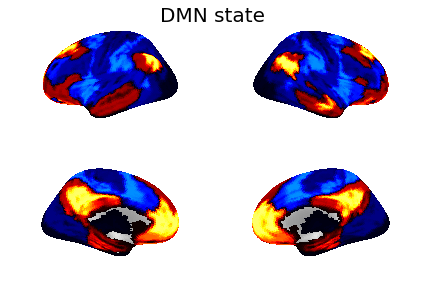

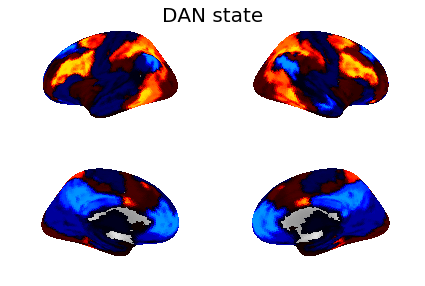

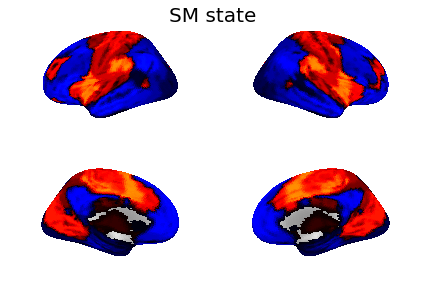

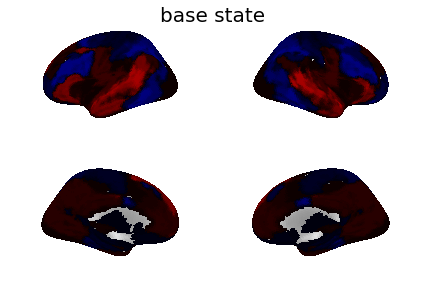

In [3]:
# reference image: MNI template
ref_img = load_img(loaddir+'fmri/MNI152_T1_3mm_brain.nii.gz')

for stt in range(1,nstate+1):
    # images are reconstructed using the HMM-inferred 25-parcel mean activity patterns of the four states
    state = load_img(loaddir+'fmri/state'+str(stt)+'_raw.nii.gz')
    state = state.dataobj[:]
    state_zmap = new_img_like(ref_img,state)

    # volume to surface reconstruction
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
    surface_left = surface.vol_to_surf(state_zmap, fsaverage.pial_left)
    surface_right = surface.vol_to_surf(state_zmap, fsaverage.pial_right)

    sns.set_context('paper')
    fig, ((a, b),(c, d)) = plt.subplots(2, 2, subplot_kw={'projection': '3d'})

    plot_surf_stat_map(fsaverage.infl_left, surface_left, hemi='left',
                       view='lateral', bg_map=fsaverage.sulc_left, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=a)
    plot_surf_stat_map(fsaverage.infl_right, surface_right, hemi='right',
                       view='lateral', bg_map=fsaverage.sulc_right, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=b)
    plot_surf_stat_map(fsaverage.infl_left, surface_left, hemi='left',
                       view='medial',bg_map=fsaverage.sulc_left, threshold=.0001, cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=c)
    plot_surf_stat_map(fsaverage.infl_right, surface_right, hemi='right',
                       view='medial',bg_map=fsaverage.sulc_right, threshold=.0001,cmap='cold_hot',
                       vmax=1.2, symmetric_cbar=1, colorbar=False, axes=d)
    plt.tight_layout()
    plt.suptitle(statename[stt-1]+' state', fontsize=20)

## Covariance matrix (Figure 1b)

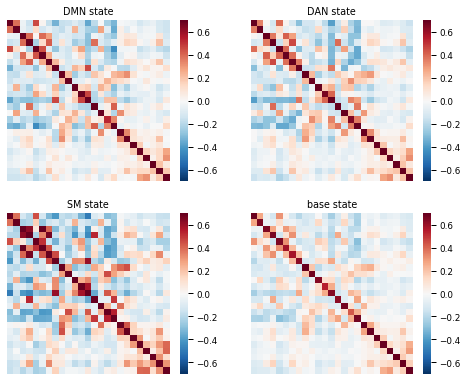

In [4]:
# Visualize HMM-inferred covariance patterns of the four states
Covars = scipy.io.loadmat(loaddir+'fmri/hmmmodel.mat')['Covars']
fig = plt.subplots(figsize=(8,6.5))
plt.subplot(221)
sns.heatmap(Covars[0,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('DMN state')
plt.subplot(222)
sns.heatmap(Covars[1,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('DAN state')
plt.subplot(223)
sns.heatmap(Covars[2,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('SM state')
plt.subplot(224)
sns.heatmap(Covars[3,:,:],vmin=-0.7,vmax=0.7,cmap='RdBu_r',cbar=True, xticklabels=False, yticklabels=False)
plt.title('base state')
plt.show()

## Latent state sequence (Figure 4a)

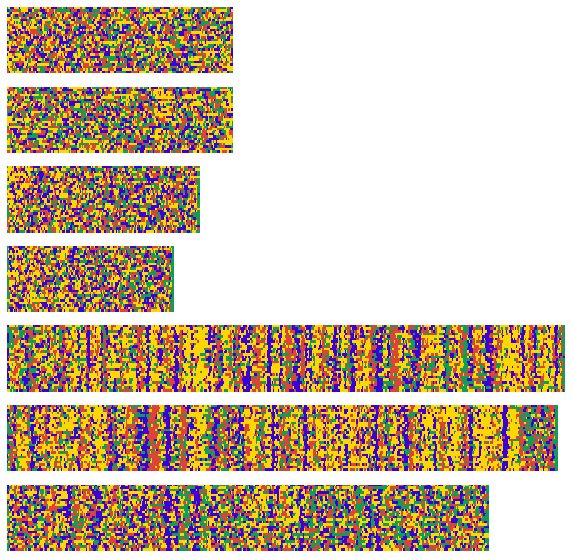

In [5]:
fig = plt.subplots(figsize=(10, 10))
for i, cdt in enumerate(condition):
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]
    if cdt=='sitcomep1': # missing sitcom episode 1 fMRI scan of one participant
        seq = np.delete(seq, 25,0)
    plt.subplot(7,1,i+1)
    sns.heatmap(seq, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    plt.xlim([0,1486])

## Pairwise participant latent state similarity (Figure 4c)

In [6]:
print('Pairwise participant latent state similarity (%)')
pvals = []
nulliter=1000
for i, cdt in enumerate(condition):
    seq = scipy.io.loadmat(loaddir+'fmri/hmmoutput.mat')[cdt]
    if cdt=='sitcomep1':
        seq = np.delete(seq, 25,0)
    
    # compute pairwise synchrony
    pairsync = []
    for s1 in range(seq.shape[0]-1):
        for s2 in range(s1+1,seq.shape[0]):
            s1seq = seq[s1,:]
            s2seq = seq[s2,:]
            pairsync.append(np.sum(s1seq==s2seq)/len(s1seq))
    pairsync=np.asarray(pairsync)
    print(' - '+cdt+': '+str(np.round(np.mean(pairsync)*100,2))+' +/- '+str(np.round(np.std(pairsync)*100,2))+'%')
    
    # chance distribution: circular-shift latent state sequence
    pairsync_null = []
    for niter in range(nulliter):
        pn = []
        for s1 in range(seq.shape[0]-1):
            for s2 in range(s1+1,seq.shape[0]):
                s1seq = np.roll(seq[s1,:], np.random.randint(seq.shape[1]-20)+10)
                s2seq = np.roll(seq[s2,:], np.random.randint(seq.shape[1]-20)+10)
                pn.append(np.sum(s1seq==s2seq)/len(s1seq))
        pairsync_null.append(np.mean(np.array(pn)))
    pairsync_null=np.asarray(pairsync_null)
    
    # compute p values (two-tailed test)
    rl = np.mean(pairsync)-np.mean(pairsync_null)
    nl = pairsync_null-np.mean(pairsync_null)
    p = (1+len(np.where(np.abs(rl)<=np.abs(nl))[0]))/(1+nulliter)
    pvals.append(p)

Pairwise participant latent state similarity (%)
 - rest1: 25.81 +/- 4.0%
 - rest2: 25.84 +/- 4.08%
 - gradCPTface: 27.27 +/- 4.01%
 - gradCPTscene: 28.16 +/- 3.96%
 - sitcomep1: 40.81 +/- 3.84%
 - sitcomep2: 40.79 +/- 3.27%
 - documentary: 30.39 +/- 3.38%


In [7]:
qvals = fdrcorrection(pvals)[1]
print('Two-tailed non parametric permutation test')
for i, cdt in enumerate(condition):
    print(' - '+cdt+': FDR-p='+str(np.round(qvals[i],3)))

Two-tailed non parametric permutation test
 - rest1: FDR-p=0.23
 - rest2: FDR-p=0.183
 - gradCPTface: FDR-p=0.001
 - gradCPTscene: FDR-p=0.001
 - sitcomep1: FDR-p=0.001
 - sitcomep2: FDR-p=0.001
 - documentary: FDR-p=0.001
